<a href="https://colab.research.google.com/github/NK2108/Deep-Learning/blob/main/emo_rec_DL_only_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np

import os, glob, pickle
import sys

import librosa
import librosa.display

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, KFold
from IPython.display import Audio

import tensorflow as tf
import keras
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
Ravdess = "/content/drive/MyDrive/speech-emotion-recognition-ravdess-data/samples/"

In [ ]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

In [ ]:
file_emotion,file_path = [],[]

for file in glob.glob("/content/drive/MyDrive/speech-emotion-recognition-ravdess-data/samples/*.wav"):

    file_name=os.path.basename(file)
    emotion=emotions[file_name.split("-")[2]]

    file_emotion.append(emotion)
    file_path.append(Ravdess+file_name)
        
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)
Ravdess_df = Ravdess_df[Ravdess_df.Emotions != 'neutral']
Ravdess_df

,Emotions,Path
1,sad,/content/drive/MyDrive/speech-emotion-recognit...
2,disgust,/content/drive/MyDrive/speech-emotion-recognit...
3,calm,/content/drive/MyDrive/speech-emotion-recognit...
4,happy,/content/drive/MyDrive/speech-emotion-recognit...
5,angry,/content/drive/MyDrive/speech-emotion-recognit...
...,...,...
1438,angry,/content/drive/MyDrive/speech-emotion-recognit...
1439,calm,/content/drive/MyDrive/speech-emotion-recognit...
1440,calm,/content/drive/MyDrive/speech-emotion-recognit...
1441,sad,/content/drive/MyDrive/speech-emotion-recognit...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


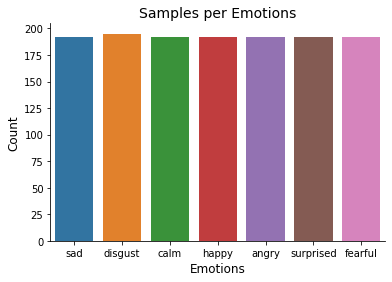

In [ ]:
plt.title('Samples per Emotions', size=14)
sns.countplot(Ravdess_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

**Adding noise, stretch, shift, or pitch**

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

path = np.array(Ravdess_df.Path)[1]
data, sample_rate = librosa.load(path)


In [ ]:
def extract_features(data):
    # Zero Crossing Rate: Signal-change rate
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma standard Furrier transfer: represent the intensity of the twelve distinctive pitch classes
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) 

    # Mel Frequency Cepstral Coefficients: from a spectral representation, freq bands distributed in mel-scale
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) 

    # Root Mean Square Value for each frame of sample
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))

    # MelSpectogram: visualization of the freq spectrum of a signal, mel-scale mimics how the human ear works
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) 
    
    return result

def get_features(path): #first step of pre-processing
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.6, offset=0.4)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) 
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3))
    
    return result

In [ ]:
X, Y = [], []
for path, emotion in zip(Ravdess_df.Path, Ravdess_df.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

len(X), len(Y), Ravdess_df.Path.shape

(4041, 4041, (1347,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y

Features

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.146205,0.667742,0.650311,0.605284,0.640242,0.584214,0.554824,0.560428,0.653882,0.703217,...,4.851268e-12,4.311642e-12,3.908758e-12,3.596597e-12,3.354412e-12,3.170622e-12,3.032781e-12,2.938114e-12,2.880097e-12,sad
1,0.244642,0.733383,0.709812,0.699881,0.744410,0.704187,0.634433,0.605040,0.663114,0.701234,...,5.387681e-05,5.445143e-05,5.725535e-05,5.545740e-05,5.770702e-05,5.841550e-05,5.816804e-05,5.424025e-05,5.443483e-05,sad
2,0.145794,0.622263,0.696846,0.669922,0.648794,0.670240,0.557148,0.536304,0.582282,0.706324,...,7.884864e-12,9.023218e-12,6.872001e-12,6.366100e-12,5.126208e-12,4.455651e-12,4.067148e-12,4.626031e-12,6.272078e-12,sad
3,0.131553,0.511452,0.517433,0.523196,0.569519,0.541172,0.582609,0.571208,0.617602,0.674876,...,1.027169e-13,9.975344e-14,9.628800e-14,9.274737e-14,8.946512e-14,8.669277e-14,8.446525e-14,8.280891e-14,8.180561e-14,disgust
4,0.175773,0.554984,0.552639,0.583893,0.590958,0.585796,0.573632,0.574290,0.631031,0.677452,...,4.691153e-07,4.557188e-07,4.829260e-07,4.660643e-07,4.748615e-07,4.752699e-07,4.697011e-07,4.944736e-07,4.627677e-07,disgust
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4036,0.283207,0.568579,0.580584,0.659019,0.684547,0.642799,0.600567,0.626884,0.784939,0.819943,...,4.909869e-06,4.945893e-06,4.845030e-06,4.626298e-06,4.794590e-06,5.158462e-06,5.012097e-06,4.890467e-06,4.886241e-06,sad
4037,0.093481,0.468669,0.430125,0.426217,0.525552,0.577744,0.539737,0.577869,0.627450,0.773411,...,3.919815e-12,1.799201e-12,1.148143e-12,1.852405e-12,1.885976e-12,1.062264e-12,9.862020e-13,1.501526e-12,1.249907e-12,sad
4038,0.157022,0.601161,0.642363,0.591389,0.599222,0.567285,0.537874,0.562058,0.590552,0.649399,...,5.162014e-14,4.336369e-14,3.761053e-14,3.341838e-14,3.030565e-14,2.803135e-14,2.636821e-14,2.523700e-14,2.457089e-14,disgust
4039,0.337093,0.836179,0.842234,0.832196,0.837614,0.773029,0.693287,0.698197,0.736010,0.754986,...,1.527360e-04,1.494236e-04,1.447873e-04,1.432060e-04,1.479485e-04,1.457239e-04,1.508656e-04,1.483201e-04,1.470305e-04,disgust


**Second step of Pre-Processing**

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=6, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3030, 162), (3030, 7), (1011, 162), (1011, 7))

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3030, 162), (3030, 7), (1011, 162), (1011, 7))

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3030, 162, 1), (3030, 7), (1011, 162, 1), (1011, 7))

**Model deployment**

In [ ]:
!pip install pyyaml h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
model=Sequential()

model.add(keras.layers.LSTM(128, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
model.add(keras.layers.LSTM(128))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=7, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 162, 128)          66560     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 7)                 231       
                                                                 
Total params: 202,503
Trainable params: 202,503
Non-trainable params: 0
_________________________________________________________________


**Loop**

In [ ]:
model.save("/content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf", save_format='tf')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


In [ ]:
eps=60
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=3, min_lr=0.0000001)
mcp_save = ModelCheckpoint('/content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf', save_best_only=True, monitor='accuracy', 
                           mode='max', save_freq='epoch')

history=model.fit(x_train, y_train, batch_size=64, epochs=eps, validation_data=(x_test, y_test), callbacks=[rlrp, mcp_save])

Epoch 1/60
48/48 [==============================] - ETA: 0s - loss: 1.8844 - accuracy: 0.1908

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 58s 1s/step - loss: 1.8844 - accuracy: 0.1908 - val_loss: 1.8404 - val_accuracy: 0.2364 - lr: 0.0010
Epoch 2/60
48/48 [==============================] - ETA: 0s - loss: 1.8368 - accuracy: 0.2271

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 39s 808ms/step - loss: 1.8368 - accuracy: 0.2271 - val_loss: 1.8429 - val_accuracy: 0.1602 - lr: 0.0010
Epoch 3/60
48/48 [==============================] - ETA: 0s - loss: 1.8149 - accuracy: 0.2320

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 40s 833ms/step - loss: 1.8149 - accuracy: 0.2320 - val_loss: 1.7886 - val_accuracy: 0.2512 - lr: 0.0010
Epoch 4/60
48/48 [==============================] - ETA: 0s - loss: 1.8075 - accuracy: 0.2462

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 39s 812ms/step - loss: 1.8075 - accuracy: 0.2462 - val_loss: 1.7885 - val_accuracy: 0.2710 - lr: 0.0010
Epoch 5/60
48/48 [==============================] - ETA: 0s - loss: 1.7912 - accuracy: 0.2548

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 39s 810ms/step - loss: 1.7912 - accuracy: 0.2548 - val_loss: 1.7683 - val_accuracy: 0.2938 - lr: 0.0010
Epoch 6/60
48/48 [==============================] - 30s 633ms/step - loss: 1.7921 - accuracy: 0.2505 - val_loss: 1.7969 - val_accuracy: 0.2018 - lr: 0.0010
Epoch 7/60
48/48 [==============================] - ETA: 0s - loss: 1.7682 - accuracy: 0.2653

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 39s 814ms/step - loss: 1.7682 - accuracy: 0.2653 - val_loss: 1.7335 - val_accuracy: 0.2957 - lr: 0.0010
Epoch 8/60
48/48 [==============================] - ETA: 0s - loss: 1.7643 - accuracy: 0.2686

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 39s 814ms/step - loss: 1.7643 - accuracy: 0.2686 - val_loss: 1.7157 - val_accuracy: 0.2948 - lr: 0.0010
Epoch 9/60
48/48 [==============================] - 30s 629ms/step - loss: 1.7641 - accuracy: 0.2677 - val_loss: 1.7114 - val_accuracy: 0.2957 - lr: 0.0010
Epoch 10/60
48/48 [==============================] - 29s 606ms/step - loss: 1.7635 - accuracy: 0.2640 - val_loss: 1.7343 - val_accuracy: 0.3046 - lr: 0.0010
Epoch 11/60
48/48 [==============================] - ETA: 0s - loss: 1.7529 - accuracy: 0.2749

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 39s 816ms/step - loss: 1.7529 - accuracy: 0.2749 - val_loss: 1.8044 - val_accuracy: 0.2700 - lr: 0.0010
Epoch 12/60
48/48 [==============================] - 29s 611ms/step - loss: 1.7767 - accuracy: 0.2558 - val_loss: 1.7394 - val_accuracy: 0.2720 - lr: 0.0010
Epoch 13/60
48/48 [==============================] - 29s 606ms/step - loss: 1.7601 - accuracy: 0.2581 - val_loss: 1.7341 - val_accuracy: 0.2977 - lr: 0.0010
Epoch 14/60
48/48 [==============================] - ETA: 0s - loss: 1.7285 - accuracy: 0.2838

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 39s 815ms/step - loss: 1.7285 - accuracy: 0.2838 - val_loss: 1.7384 - val_accuracy: 0.2453 - lr: 0.0010
Epoch 15/60
48/48 [==============================] - 29s 609ms/step - loss: 1.7580 - accuracy: 0.2782 - val_loss: 1.7638 - val_accuracy: 0.2839 - lr: 0.0010
Epoch 16/60
48/48 [==============================] - 29s 607ms/step - loss: 1.7700 - accuracy: 0.2759 - val_loss: 1.7212 - val_accuracy: 0.2967 - lr: 0.0010
Epoch 17/60
48/48 [==============================] - 29s 608ms/step - loss: 1.7415 - accuracy: 0.2716 - val_loss: 1.6875 - val_accuracy: 0.3136 - lr: 0.0010
Epoch 18/60
48/48 [==============================] - ETA: 0s - loss: 1.7035 - accuracy: 0.3030

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 38s 798ms/step - loss: 1.7035 - accuracy: 0.3030 - val_loss: 1.6615 - val_accuracy: 0.3264 - lr: 4.0000e-04
Epoch 19/60
48/48 [==============================] - ETA: 0s - loss: 1.6884 - accuracy: 0.3129

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 39s 810ms/step - loss: 1.6884 - accuracy: 0.3129 - val_loss: 1.6636 - val_accuracy: 0.3274 - lr: 4.0000e-04
Epoch 20/60
48/48 [==============================] - ETA: 0s - loss: 1.6784 - accuracy: 0.3195

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 39s 818ms/step - loss: 1.6784 - accuracy: 0.3195 - val_loss: 1.6557 - val_accuracy: 0.3452 - lr: 4.0000e-04
Epoch 21/60
48/48 [==============================] - 29s 607ms/step - loss: 1.6887 - accuracy: 0.3050 - val_loss: 1.6729 - val_accuracy: 0.3314 - lr: 4.0000e-04
Epoch 22/60
48/48 [==============================] - 29s 605ms/step - loss: 1.6862 - accuracy: 0.3129 - val_loss: 1.6417 - val_accuracy: 0.3482 - lr: 4.0000e-04
Epoch 23/60
48/48 [==============================] - 29s 603ms/step - loss: 1.6658 - accuracy: 0.3132 - val_loss: 1.6399 - val_accuracy: 0.3333 - lr: 4.0000e-04
Epoch 24/60
48/48 [==============================] - 29s 603ms/step - loss: 1.6631 - accuracy: 0.3135 - val_loss: 1.6953 - val_accuracy: 0.3185 - lr: 4.0000e-04
Epoch 25/60
48/48 [==============================] - 29s 609ms/step - loss: 1.6962 - accuracy: 0.3069 - val_loss: 1.6755 - val_accuracy: 0.3205 - lr: 4.0000e-04
Epoch 26/60
48/48 [===========================

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 38s 793ms/step - loss: 1.6628 - accuracy: 0.3254 - val_loss: 1.6432 - val_accuracy: 0.3294 - lr: 4.0000e-04
Epoch 27/60
48/48 [==============================] - 29s 607ms/step - loss: 1.6769 - accuracy: 0.3013 - val_loss: 1.6493 - val_accuracy: 0.3482 - lr: 4.0000e-04
Epoch 28/60
48/48 [==============================] - 29s 601ms/step - loss: 1.6623 - accuracy: 0.3208 - val_loss: 1.6504 - val_accuracy: 0.3373 - lr: 4.0000e-04
Epoch 29/60
48/48 [==============================] - 29s 605ms/step - loss: 1.6564 - accuracy: 0.3231 - val_loss: 1.6492 - val_accuracy: 0.3561 - lr: 4.0000e-04
Epoch 30/60
48/48 [==============================] - 29s 606ms/step - loss: 1.6698 - accuracy: 0.3218 - val_loss: 1.6300 - val_accuracy: 0.3581 - lr: 4.0000e-04
Epoch 31/60
48/48 [==============================] - ETA: 0s - loss: 1.6434 - accuracy: 0.3287

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 39s 814ms/step - loss: 1.6434 - accuracy: 0.3287 - val_loss: 1.6400 - val_accuracy: 0.3244 - lr: 4.0000e-04
Epoch 32/60
48/48 [==============================] - ETA: 0s - loss: 1.6273 - accuracy: 0.3304

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 39s 809ms/step - loss: 1.6273 - accuracy: 0.3304 - val_loss: 1.6249 - val_accuracy: 0.3442 - lr: 4.0000e-04
Epoch 33/60
48/48 [==============================] - ETA: 0s - loss: 1.6420 - accuracy: 0.3323

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 39s 810ms/step - loss: 1.6420 - accuracy: 0.3323 - val_loss: 1.6319 - val_accuracy: 0.3521 - lr: 4.0000e-04
Epoch 34/60
48/48 [==============================] - 29s 604ms/step - loss: 1.6543 - accuracy: 0.3248 - val_loss: 1.6157 - val_accuracy: 0.3531 - lr: 4.0000e-04
Epoch 35/60
48/48 [==============================] - ETA: 0s - loss: 1.6171 - accuracy: 0.3439

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 38s 806ms/step - loss: 1.6171 - accuracy: 0.3439 - val_loss: 1.6185 - val_accuracy: 0.3541 - lr: 4.0000e-04
Epoch 36/60
48/48 [==============================] - 29s 605ms/step - loss: 1.6095 - accuracy: 0.3432 - val_loss: 1.6529 - val_accuracy: 0.3403 - lr: 4.0000e-04
Epoch 37/60
48/48 [==============================] - ETA: 0s - loss: 1.6154 - accuracy: 0.3479

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 39s 809ms/step - loss: 1.6154 - accuracy: 0.3479 - val_loss: 1.5851 - val_accuracy: 0.3729 - lr: 4.0000e-04
Epoch 38/60
48/48 [==============================] - 29s 606ms/step - loss: 1.6095 - accuracy: 0.3396 - val_loss: 1.6023 - val_accuracy: 0.3670 - lr: 4.0000e-04
Epoch 39/60
48/48 [==============================] - ETA: 0s - loss: 1.5955 - accuracy: 0.3647

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 38s 789ms/step - loss: 1.5955 - accuracy: 0.3647 - val_loss: 1.5904 - val_accuracy: 0.3729 - lr: 4.0000e-04
Epoch 40/60
48/48 [==============================] - 29s 604ms/step - loss: 1.6026 - accuracy: 0.3587 - val_loss: 1.5858 - val_accuracy: 0.3788 - lr: 4.0000e-04
Epoch 41/60
48/48 [==============================] - 29s 602ms/step - loss: 1.5876 - accuracy: 0.3647 - val_loss: 1.5873 - val_accuracy: 0.3798 - lr: 4.0000e-04
Epoch 42/60
48/48 [==============================] - 29s 603ms/step - loss: 1.5806 - accuracy: 0.3614 - val_loss: 1.6608 - val_accuracy: 0.3056 - lr: 4.0000e-04
Epoch 43/60
48/48 [==============================] - 29s 602ms/step - loss: 1.6005 - accuracy: 0.3403 - val_loss: 1.5746 - val_accuracy: 0.3759 - lr: 4.0000e-04
Epoch 44/60
48/48 [==============================] - 29s 606ms/step - loss: 1.5806 - accuracy: 0.3597 - val_loss: 1.6090 - val_accuracy: 0.3630 - lr: 4.0000e-04
Epoch 45/60
48/48 [===========================

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 39s 812ms/step - loss: 1.5631 - accuracy: 0.3693 - val_loss: 1.6572 - val_accuracy: 0.3452 - lr: 4.0000e-04
Epoch 46/60
48/48 [==============================] - ETA: 0s - loss: 1.5695 - accuracy: 0.3713

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 39s 811ms/step - loss: 1.5695 - accuracy: 0.3713 - val_loss: 1.5838 - val_accuracy: 0.3670 - lr: 4.0000e-04
Epoch 47/60
48/48 [==============================] - ETA: 0s - loss: 1.5526 - accuracy: 0.3733

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 38s 794ms/step - loss: 1.5526 - accuracy: 0.3733 - val_loss: 1.6014 - val_accuracy: 0.3650 - lr: 4.0000e-04
Epoch 48/60
48/48 [==============================] - ETA: 0s - loss: 1.5630 - accuracy: 0.3769

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 39s 814ms/step - loss: 1.5630 - accuracy: 0.3769 - val_loss: 1.5962 - val_accuracy: 0.3581 - lr: 4.0000e-04
Epoch 49/60
48/48 [==============================] - 29s 605ms/step - loss: 1.5584 - accuracy: 0.3752 - val_loss: 1.5730 - val_accuracy: 0.3759 - lr: 4.0000e-04
Epoch 50/60
48/48 [==============================] - ETA: 0s - loss: 1.5425 - accuracy: 0.3835

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 38s 803ms/step - loss: 1.5425 - accuracy: 0.3835 - val_loss: 1.6035 - val_accuracy: 0.3591 - lr: 4.0000e-04
Epoch 51/60
48/48 [==============================] - ETA: 0s - loss: 1.5312 - accuracy: 0.3904

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 38s 804ms/step - loss: 1.5312 - accuracy: 0.3904 - val_loss: 1.6656 - val_accuracy: 0.3403 - lr: 4.0000e-04
Epoch 52/60
48/48 [==============================] - ETA: 0s - loss: 1.5334 - accuracy: 0.3934

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 38s 804ms/step - loss: 1.5334 - accuracy: 0.3934 - val_loss: 1.5737 - val_accuracy: 0.3818 - lr: 4.0000e-04
Epoch 53/60
48/48 [==============================] - 29s 606ms/step - loss: 1.5215 - accuracy: 0.3901 - val_loss: 1.5592 - val_accuracy: 0.3719 - lr: 4.0000e-04
Epoch 54/60
48/48 [==============================] - ETA: 0s - loss: 1.5248 - accuracy: 0.3941

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 38s 804ms/step - loss: 1.5248 - accuracy: 0.3941 - val_loss: 1.5766 - val_accuracy: 0.3709 - lr: 4.0000e-04
Epoch 55/60
48/48 [==============================] - ETA: 0s - loss: 1.5159 - accuracy: 0.3947

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 38s 805ms/step - loss: 1.5159 - accuracy: 0.3947 - val_loss: 1.5712 - val_accuracy: 0.3769 - lr: 4.0000e-04
Epoch 56/60
48/48 [==============================] - 29s 604ms/step - loss: 1.4999 - accuracy: 0.3927 - val_loss: 1.5733 - val_accuracy: 0.3689 - lr: 4.0000e-04
Epoch 57/60
48/48 [==============================] - 29s 603ms/step - loss: 1.5446 - accuracy: 0.3805 - val_loss: 1.5669 - val_accuracy: 0.3699 - lr: 4.0000e-04
Epoch 58/60
48/48 [==============================] - 29s 603ms/step - loss: 1.4978 - accuracy: 0.3921 - val_loss: 1.5357 - val_accuracy: 0.3838 - lr: 4.0000e-04
Epoch 59/60
48/48 [==============================] - ETA: 0s - loss: 1.4830 - accuracy: 0.4086

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 39s 808ms/step - loss: 1.4830 - accuracy: 0.4086 - val_loss: 1.5541 - val_accuracy: 0.3670 - lr: 4.0000e-04
Epoch 60/60
48/48 [==============================] - 29s 603ms/step - loss: 1.4878 - accuracy: 0.4043 - val_loss: 1.5457 - val_accuracy: 0.3907 - lr: 4.0000e-04


32/32 [==============================] - 3s 88ms/step - loss: 1.5457 - accuracy: 0.3907
Accuracy of our model on test data :  39.07022774219513 %


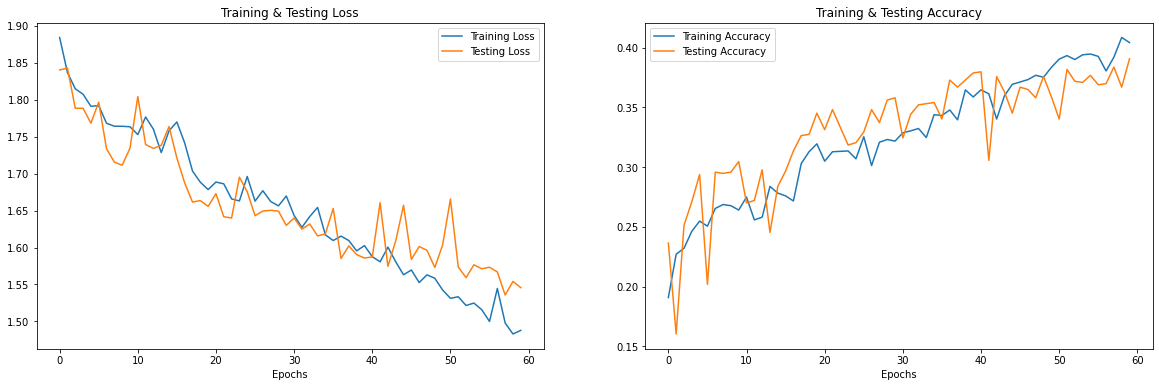

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(eps)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
history = tf.keras.models.load_model("/content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf")

earlyStopping = EarlyStopping(monitor='accuracy', patience=6, verbose=0, mode='max')
mcp_save_2 = ModelCheckpoint('/content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf', save_best_only=True, monitor='accuracy', 
                           mode='max', save_freq='epoch')
inc_accuracy = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=6, verbose=0, mode='max')

history = model.fit(x_train, y_train, batch_size=64, epochs=eps, validation_data=(x_test, y_test), callbacks=[earlyStopping, mcp_save_2, inc_accuracy])

Epoch 1/60
48/48 [==============================] - ETA: 0s - loss: 1.4846 - accuracy: 0.4046

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 38s 799ms/step - loss: 1.4846 - accuracy: 0.4046 - val_loss: 1.5544 - val_accuracy: 0.3749 - lr: 4.0000e-04
Epoch 2/60
48/48 [==============================] - ETA: 0s - loss: 1.4846 - accuracy: 0.4083

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 38s 804ms/step - loss: 1.4846 - accuracy: 0.4083 - val_loss: 1.5557 - val_accuracy: 0.3798 - lr: 4.0000e-04
Epoch 3/60
48/48 [==============================] - ETA: 0s - loss: 1.4744 - accuracy: 0.4102

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 38s 806ms/step - loss: 1.4744 - accuracy: 0.4102 - val_loss: 1.5430 - val_accuracy: 0.3808 - lr: 4.0000e-04
Epoch 4/60
48/48 [==============================] - 29s 604ms/step - loss: 1.4637 - accuracy: 0.4102 - val_loss: 1.5473 - val_accuracy: 0.3887 - lr: 4.0000e-04
Epoch 5/60
48/48 [==============================] - ETA: 0s - loss: 1.4452 - accuracy: 0.4142

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 38s 804ms/step - loss: 1.4452 - accuracy: 0.4142 - val_loss: 1.5490 - val_accuracy: 0.3937 - lr: 4.0000e-04
Epoch 6/60
48/48 [==============================] - 29s 602ms/step - loss: 1.4725 - accuracy: 0.4040 - val_loss: 1.5427 - val_accuracy: 0.3867 - lr: 4.0000e-04
Epoch 7/60
48/48 [==============================] - ETA: 0s - loss: 1.4531 - accuracy: 0.4188

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 38s 789ms/step - loss: 1.4531 - accuracy: 0.4188 - val_loss: 1.5311 - val_accuracy: 0.3907 - lr: 4.0000e-04
Epoch 8/60
48/48 [==============================] - ETA: 0s - loss: 1.4526 - accuracy: 0.4241

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 38s 806ms/step - loss: 1.4526 - accuracy: 0.4241 - val_loss: 1.5288 - val_accuracy: 0.3927 - lr: 4.0000e-04
Epoch 9/60
48/48 [==============================] - 29s 607ms/step - loss: 1.4420 - accuracy: 0.4162 - val_loss: 1.5213 - val_accuracy: 0.3917 - lr: 4.0000e-04
Epoch 10/60
48/48 [==============================] - 29s 603ms/step - loss: 1.4327 - accuracy: 0.4231 - val_loss: 1.5347 - val_accuracy: 0.3976 - lr: 4.0000e-04
Epoch 11/60
48/48 [==============================] - 29s 604ms/step - loss: 1.4394 - accuracy: 0.4218 - val_loss: 1.5367 - val_accuracy: 0.3986 - lr: 4.0000e-04
Epoch 12/60
48/48 [==============================] - ETA: 0s - loss: 1.4263 - accuracy: 0.4317

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 38s 806ms/step - loss: 1.4263 - accuracy: 0.4317 - val_loss: 1.5279 - val_accuracy: 0.3917 - lr: 4.0000e-04
Epoch 13/60
48/48 [==============================] - ETA: 0s - loss: 1.4019 - accuracy: 0.4409

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 38s 804ms/step - loss: 1.4019 - accuracy: 0.4409 - val_loss: 1.6305 - val_accuracy: 0.3739 - lr: 4.0000e-04
Epoch 14/60
48/48 [==============================] - 29s 603ms/step - loss: 1.4078 - accuracy: 0.4409 - val_loss: 1.5513 - val_accuracy: 0.3996 - lr: 4.0000e-04
Epoch 15/60
48/48 [==============================] - 29s 603ms/step - loss: 1.4383 - accuracy: 0.4337 - val_loss: 1.6051 - val_accuracy: 0.3739 - lr: 4.0000e-04
Epoch 16/60
48/48 [==============================] - 29s 603ms/step - loss: 1.4203 - accuracy: 0.4333 - val_loss: 1.5314 - val_accuracy: 0.4085 - lr: 4.0000e-04
Epoch 17/60
48/48 [==============================] - ETA: 0s - loss: 1.3949 - accuracy: 0.4462

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 38s 794ms/step - loss: 1.3949 - accuracy: 0.4462 - val_loss: 1.5508 - val_accuracy: 0.3848 - lr: 4.0000e-04
Epoch 18/60
48/48 [==============================] - 29s 601ms/step - loss: 1.4061 - accuracy: 0.4409 - val_loss: 1.5346 - val_accuracy: 0.4006 - lr: 4.0000e-04
Epoch 19/60
48/48 [==============================] - ETA: 0s - loss: 1.3720 - accuracy: 0.4498

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 39s 813ms/step - loss: 1.3720 - accuracy: 0.4498 - val_loss: 1.5917 - val_accuracy: 0.3947 - lr: 4.0000e-04
Epoch 20/60
48/48 [==============================] - 29s 607ms/step - loss: 1.4084 - accuracy: 0.4469 - val_loss: 1.5244 - val_accuracy: 0.3996 - lr: 4.0000e-04
Epoch 21/60
48/48 [==============================] - ETA: 0s - loss: 1.3532 - accuracy: 0.4667

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 38s 804ms/step - loss: 1.3532 - accuracy: 0.4667 - val_loss: 1.5513 - val_accuracy: 0.3907 - lr: 4.0000e-04
Epoch 22/60
48/48 [==============================] - 29s 604ms/step - loss: 1.3886 - accuracy: 0.4432 - val_loss: 1.5246 - val_accuracy: 0.3966 - lr: 4.0000e-04
Epoch 23/60
48/48 [==============================] - 29s 603ms/step - loss: 1.3597 - accuracy: 0.4640 - val_loss: 1.5275 - val_accuracy: 0.4085 - lr: 4.0000e-04
Epoch 24/60
48/48 [==============================] - 29s 600ms/step - loss: 1.3465 - accuracy: 0.4660 - val_loss: 1.4963 - val_accuracy: 0.4184 - lr: 4.0000e-04
Epoch 25/60
48/48 [==============================] - ETA: 0s - loss: 1.3363 - accuracy: 0.4736

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 38s 806ms/step - loss: 1.3363 - accuracy: 0.4736 - val_loss: 1.4964 - val_accuracy: 0.4045 - lr: 4.0000e-04
Epoch 26/60
48/48 [==============================] - 29s 606ms/step - loss: 1.3615 - accuracy: 0.4551 - val_loss: 1.5636 - val_accuracy: 0.3798 - lr: 4.0000e-04
Epoch 27/60
48/48 [==============================] - 29s 602ms/step - loss: 1.3389 - accuracy: 0.4723 - val_loss: 1.4929 - val_accuracy: 0.4135 - lr: 4.0000e-04
Epoch 28/60
48/48 [==============================] - 29s 607ms/step - loss: 1.3448 - accuracy: 0.4620 - val_loss: 1.5150 - val_accuracy: 0.4065 - lr: 4.0000e-04
Epoch 29/60
48/48 [==============================] - ETA: 0s - loss: 1.3295 - accuracy: 0.4779

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 38s 792ms/step - loss: 1.3295 - accuracy: 0.4779 - val_loss: 1.5405 - val_accuracy: 0.4125 - lr: 4.0000e-04
Epoch 30/60
48/48 [==============================] - ETA: 0s - loss: 1.3073 - accuracy: 0.4825

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 39s 814ms/step - loss: 1.3073 - accuracy: 0.4825 - val_loss: 1.5115 - val_accuracy: 0.4204 - lr: 4.0000e-04
Epoch 31/60
48/48 [==============================] - 29s 608ms/step - loss: 1.3258 - accuracy: 0.4815 - val_loss: 1.5289 - val_accuracy: 0.4065 - lr: 4.0000e-04
Epoch 32/60
48/48 [==============================] - ETA: 0s - loss: 1.2979 - accuracy: 0.4845

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 39s 810ms/step - loss: 1.2979 - accuracy: 0.4845 - val_loss: 1.5211 - val_accuracy: 0.4214 - lr: 4.0000e-04
Epoch 33/60
48/48 [==============================] - ETA: 0s - loss: 1.2939 - accuracy: 0.4881

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 38s 807ms/step - loss: 1.2939 - accuracy: 0.4881 - val_loss: 1.5162 - val_accuracy: 0.4293 - lr: 4.0000e-04
Epoch 34/60
48/48 [==============================] - 29s 602ms/step - loss: 1.3281 - accuracy: 0.4769 - val_loss: 1.5377 - val_accuracy: 0.4322 - lr: 4.0000e-04
Epoch 35/60
48/48 [==============================] - 29s 603ms/step - loss: 1.3133 - accuracy: 0.4825 - val_loss: 1.5484 - val_accuracy: 0.4105 - lr: 4.0000e-04
Epoch 36/60
48/48 [==============================] - ETA: 0s - loss: 1.2757 - accuracy: 0.5007

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 38s 802ms/step - loss: 1.2757 - accuracy: 0.5007 - val_loss: 1.5273 - val_accuracy: 0.4164 - lr: 4.0000e-04
Epoch 37/60
48/48 [==============================] - 29s 603ms/step - loss: 1.2801 - accuracy: 0.4891 - val_loss: 1.5144 - val_accuracy: 0.4273 - lr: 4.0000e-04
Epoch 38/60
48/48 [==============================] - 29s 603ms/step - loss: 1.2691 - accuracy: 0.4947 - val_loss: 1.5262 - val_accuracy: 0.4154 - lr: 4.0000e-04
Epoch 39/60
48/48 [==============================] - ETA: 0s - loss: 1.2575 - accuracy: 0.5036

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 38s 790ms/step - loss: 1.2575 - accuracy: 0.5036 - val_loss: 1.5878 - val_accuracy: 0.3947 - lr: 4.0000e-04
Epoch 40/60
48/48 [==============================] - 29s 605ms/step - loss: 1.2791 - accuracy: 0.4908 - val_loss: 1.5100 - val_accuracy: 0.4402 - lr: 4.0000e-04
Epoch 41/60
48/48 [==============================] - ETA: 0s - loss: 1.2503 - accuracy: 0.5109

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 39s 809ms/step - loss: 1.2503 - accuracy: 0.5109 - val_loss: 1.5475 - val_accuracy: 0.4085 - lr: 4.0000e-04
Epoch 42/60
48/48 [==============================] - 29s 606ms/step - loss: 1.2819 - accuracy: 0.4980 - val_loss: 1.5672 - val_accuracy: 0.4144 - lr: 4.0000e-04
Epoch 43/60
48/48 [==============================] - 29s 606ms/step - loss: 1.2426 - accuracy: 0.5083 - val_loss: 1.5866 - val_accuracy: 0.3996 - lr: 4.0000e-04
Epoch 44/60
48/48 [==============================] - ETA: 0s - loss: 1.2432 - accuracy: 0.5168

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 39s 809ms/step - loss: 1.2432 - accuracy: 0.5168 - val_loss: 1.5180 - val_accuracy: 0.4253 - lr: 4.0000e-04
Epoch 45/60
48/48 [==============================] - ETA: 0s - loss: 1.2293 - accuracy: 0.5231

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 38s 804ms/step - loss: 1.2293 - accuracy: 0.5231 - val_loss: 1.5707 - val_accuracy: 0.4144 - lr: 4.0000e-04
Epoch 46/60
48/48 [==============================] - 29s 605ms/step - loss: 1.2395 - accuracy: 0.5109 - val_loss: 1.5113 - val_accuracy: 0.4322 - lr: 4.0000e-04
Epoch 47/60
48/48 [==============================] - 29s 604ms/step - loss: 1.2626 - accuracy: 0.5053 - val_loss: 1.5787 - val_accuracy: 0.4075 - lr: 4.0000e-04
Epoch 48/60
48/48 [==============================] - 29s 602ms/step - loss: 1.2473 - accuracy: 0.5112 - val_loss: 1.5448 - val_accuracy: 0.3947 - lr: 4.0000e-04
Epoch 49/60
48/48 [==============================] - 29s 605ms/step - loss: 1.2460 - accuracy: 0.5102 - val_loss: 1.5004 - val_accuracy: 0.4293 - lr: 4.0000e-04
Epoch 50/60
48/48 [==============================] - 29s 605ms/step - loss: 1.1958 - accuracy: 0.5228 - val_loss: 1.5195 - val_accuracy: 0.4224 - lr: 4.0000e-04
Epoch 51/60
48/48 [===========================

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 38s 806ms/step - loss: 1.2135 - accuracy: 0.5274 - val_loss: 1.6148 - val_accuracy: 0.3996 - lr: 4.0000e-04
Epoch 52/60
48/48 [==============================] - 29s 603ms/step - loss: 1.2232 - accuracy: 0.5218 - val_loss: 1.5461 - val_accuracy: 0.4273 - lr: 4.0000e-04
Epoch 53/60
48/48 [==============================] - ETA: 0s - loss: 1.1826 - accuracy: 0.5452

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 38s 790ms/step - loss: 1.1826 - accuracy: 0.5452 - val_loss: 1.5462 - val_accuracy: 0.4293 - lr: 4.0000e-04
Epoch 54/60
48/48 [==============================] - 29s 604ms/step - loss: 1.1827 - accuracy: 0.5330 - val_loss: 1.5397 - val_accuracy: 0.4184 - lr: 4.0000e-04
Epoch 55/60
48/48 [==============================] - 29s 603ms/step - loss: 1.1766 - accuracy: 0.5347 - val_loss: 1.5836 - val_accuracy: 0.4065 - lr: 4.0000e-04
Epoch 56/60
48/48 [==============================] - 29s 602ms/step - loss: 1.2159 - accuracy: 0.5201 - val_loss: 1.5345 - val_accuracy: 0.4144 - lr: 4.0000e-04
Epoch 57/60
48/48 [==============================] - 29s 604ms/step - loss: 1.1661 - accuracy: 0.5406 - val_loss: 1.5438 - val_accuracy: 0.4283 - lr: 4.0000e-04
Epoch 58/60
48/48 [==============================] - 29s 603ms/step - loss: 1.1652 - accuracy: 0.5422 - val_loss: 1.5721 - val_accuracy: 0.4243 - lr: 4.0000e-04
Epoch 59/60
48/48 [===========================

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 39s 814ms/step - loss: 1.1675 - accuracy: 0.5518 - val_loss: 1.5437 - val_accuracy: 0.4283 - lr: 4.0000e-04
Epoch 60/60
48/48 [==============================] - ETA: 0s - loss: 1.1525 - accuracy: 0.5574

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 38s 803ms/step - loss: 1.1525 - accuracy: 0.5574 - val_loss: 1.5627 - val_accuracy: 0.4174 - lr: 4.0000e-04


In [ ]:
history = tf.keras.models.load_model("/content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf")

earlyStopping_1 = EarlyStopping(monitor='val_loss', patience=6, verbose=0, mode='min')
mcp_save_3 = ModelCheckpoint('/content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf', save_best_only=True, monitor='val_loss', 
                           mode='min', save_freq='epoch')
reduce_val_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=6, verbose=0, mode='min')

history = model.fit(x_train, y_train, batch_size=64, epochs=eps, validation_data=(x_test, y_test), callbacks=[earlyStopping_1, mcp_save_3, reduce_val_loss])

Epoch 1/60
48/48 [==============================] - ETA: 0s - loss: 1.1908 - accuracy: 0.5370

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 38s 801ms/step - loss: 1.1908 - accuracy: 0.5370 - val_loss: 1.5783 - val_accuracy: 0.4204 - lr: 4.0000e-04
Epoch 2/60
48/48 [==============================] - ETA: 0s - loss: 1.1579 - accuracy: 0.5495

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 38s 806ms/step - loss: 1.1579 - accuracy: 0.5495 - val_loss: 1.5677 - val_accuracy: 0.4085 - lr: 4.0000e-04
Epoch 3/60
48/48 [==============================] - 29s 603ms/step - loss: 1.1242 - accuracy: 0.5700 - val_loss: 1.5678 - val_accuracy: 0.4293 - lr: 4.0000e-04
Epoch 4/60
48/48 [==============================] - 29s 599ms/step - loss: 1.1649 - accuracy: 0.5419 - val_loss: 1.6004 - val_accuracy: 0.4026 - lr: 4.0000e-04
Epoch 5/60
48/48 [==============================] - 29s 602ms/step - loss: 1.1328 - accuracy: 0.5571 - val_loss: 1.6245 - val_accuracy: 0.4362 - lr: 4.0000e-04
Epoch 6/60
48/48 [==============================] - 29s 599ms/step - loss: 1.1136 - accuracy: 0.5650 - val_loss: 1.5873 - val_accuracy: 0.4154 - lr: 4.0000e-04
Epoch 7/60
48/48 [==============================] - 29s 598ms/step - loss: 1.1578 - accuracy: 0.5495 - val_loss: 1.6062 - val_accuracy: 0.4214 - lr: 4.0000e-04
Epoch 8/60
48/48 [==============================] -

In [ ]:
history = tf.keras.models.load_model("/content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf")

earlyStopping_2 = EarlyStopping(monitor='val_accuracy', patience=6, verbose=0, mode='max')
mcp_save_4 = ModelCheckpoint('/content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf', save_best_only=True, monitor='val_accuracy', 
                           mode='max', save_freq='epoch')
increase_val_acc = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=6, verbose=0, mode='max')
history = model.fit(x_train, y_train, batch_size=64, epochs=eps, validation_data=(x_test, y_test), callbacks=[earlyStopping_2, mcp_save_4, increase_val_acc])

Epoch 1/60
48/48 [==============================] - ETA: 0s - loss: 1.0614 - accuracy: 0.6003

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 39s 812ms/step - loss: 1.0614 - accuracy: 0.6003 - val_loss: 1.5763 - val_accuracy: 0.4293 - lr: 4.0000e-05
Epoch 2/60
48/48 [==============================] - ETA: 0s - loss: 1.0276 - accuracy: 0.6142

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 39s 809ms/step - loss: 1.0276 - accuracy: 0.6142 - val_loss: 1.5764 - val_accuracy: 0.4322 - lr: 4.0000e-05
Epoch 3/60
48/48 [==============================] - ETA: 0s - loss: 1.0092 - accuracy: 0.6224

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 38s 790ms/step - loss: 1.0092 - accuracy: 0.6224 - val_loss: 1.5817 - val_accuracy: 0.4332 - lr: 4.0000e-05
Epoch 4/60
48/48 [==============================] - ETA: 0s - loss: 1.0037 - accuracy: 0.6228

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 39s 813ms/step - loss: 1.0037 - accuracy: 0.6228 - val_loss: 1.5786 - val_accuracy: 0.4342 - lr: 4.0000e-05
Epoch 5/60
48/48 [==============================] - 29s 603ms/step - loss: 0.9979 - accuracy: 0.6231 - val_loss: 1.5927 - val_accuracy: 0.4283 - lr: 4.0000e-05
Epoch 6/60
48/48 [==============================] - 29s 599ms/step - loss: 0.9958 - accuracy: 0.6228 - val_loss: 1.5911 - val_accuracy: 0.4322 - lr: 4.0000e-05
Epoch 7/60
48/48 [==============================] - 29s 604ms/step - loss: 0.9882 - accuracy: 0.6257 - val_loss: 1.5957 - val_accuracy: 0.4263 - lr: 4.0000e-05
Epoch 8/60
48/48 [==============================] - 29s 608ms/step - loss: 0.9904 - accuracy: 0.6307 - val_loss: 1.5894 - val_accuracy: 0.4263 - lr: 4.0000e-05
Epoch 9/60
48/48 [==============================] - 29s 608ms/step - loss: 0.9806 - accuracy: 0.6343 - val_loss: 1.5972 - val_accuracy: 0.4273 - lr: 4.0000e-05
Epoch 10/60
48/48 [==============================] 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/speech-emotion-recognition-ravdess-data/speech_model_onlyLSTM.tf/assets


48/48 [==============================] - 39s 815ms/step - loss: 0.9773 - accuracy: 0.6347 - val_loss: 1.5976 - val_accuracy: 0.4441 - lr: 4.0000e-05
Epoch 11/60
48/48 [==============================] - 29s 608ms/step - loss: 0.9680 - accuracy: 0.6366 - val_loss: 1.6017 - val_accuracy: 0.4273 - lr: 4.0000e-05
Epoch 12/60
48/48 [==============================] - 29s 605ms/step - loss: 0.9698 - accuracy: 0.6436 - val_loss: 1.6199 - val_accuracy: 0.4233 - lr: 4.0000e-05
Epoch 13/60
48/48 [==============================] - 29s 606ms/step - loss: 0.9601 - accuracy: 0.6446 - val_loss: 1.6107 - val_accuracy: 0.4352 - lr: 4.0000e-05
Epoch 14/60
48/48 [==============================] - 29s 606ms/step - loss: 0.9635 - accuracy: 0.6482 - val_loss: 1.6229 - val_accuracy: 0.4253 - lr: 4.0000e-05
Epoch 15/60
48/48 [==============================] - 29s 605ms/step - loss: 0.9589 - accuracy: 0.6389 - val_loss: 1.6262 - val_accuracy: 0.4382 - lr: 4.0000e-05
Epoch 16/60
48/48 [===========================

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test_ = encoder.inverse_transform(y_test)

In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test_.flatten()

df

,Predicted Labels,Actual Labels
0,fearful,disgust
1,fearful,angry
2,surprised,sad
3,fearful,sad
4,calm,calm
...,...,...
1006,disgust,disgust
1007,calm,calm
1008,surprised,fearful
1009,disgust,angry


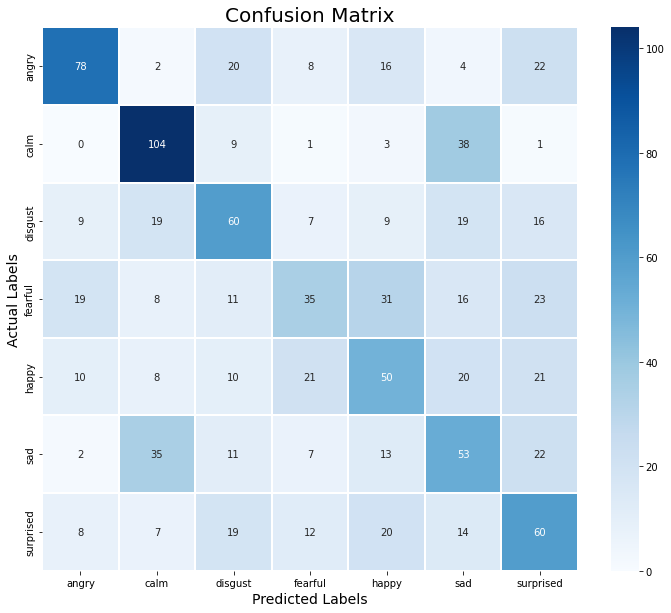

In [ ]:
cm = confusion_matrix(y_test_, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test_, y_pred))

              precision    recall  f1-score   support

       angry       0.62      0.52      0.57       150
        calm       0.57      0.67      0.61       156
     disgust       0.43      0.43      0.43       139
     fearful       0.38      0.24      0.30       143
       happy       0.35      0.36      0.35       140
         sad       0.32      0.37      0.35       143
   surprised       0.36      0.43      0.39       140

    accuracy                           0.44      1011
   macro avg       0.43      0.43      0.43      1011
weighted avg       0.44      0.44      0.43      1011



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 162, 128)          66560     
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 7)                 231       
                                                                 
Total params: 202,503
Trainable params: 202,503
Non-trainable params: 0
_________________________________________________________________
